- - -
    Данный ноутбук является второй частью проекта. Он применяет модель полученную в ноутбуке project_stocks_ml, для выполнения задач проекта: отчетность по эффективности товарного запаса и товарной матрицы с учетом выделяемых кластеров. Построение отчета в динамике. А также построение рекомендаций по заказу для закупщика. Начало ноутбука будет во многом похожим, на предыдущей. Однако создание и обработка признаков будут с минимум комментариев, а избыточные признаки, которые не были отобраны для кластеризации создаваться не будут. После этого в этом ноутбке я применяю уже готовую модель классификации к новым данным.

**Зафиксируем глобальные переменные**

In [350]:
region = 'ШМТ' #Выберем склад

**Загрузка библиотек**

In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import re
import pickle

%matplotlib inline
plt.style.use('seaborn')

C:\Users\killr\AppData\Local\Temp\ipykernel_15468\3098669105.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


**Загрузка данных**

In [352]:
Sales = pd.read_excel('data\Загрузка продажи '+region+'.xlsx')
Stocks = pd.read_excel('data\Остатки загрузка '+region+'.xlsx')
Nomen = pd.read_excel('data\Загрузка справочник '+region+'.xlsx')

Sales = Sales.rename({'Дата':'ДАТА', 'Артикул':'АРТИКУЛ', 'Менеджер':'МЕНЕДЖЕР','Клиент':'КЛИЕНТ','Продажа ШТ':'ПРОДАЖА ШТ'}, axis=1)

Stocks = Stocks.fillna({'Цена': Stocks['Цена'].median(), 'Расход': 0, 'Кон ост': 0})
Stocks = Stocks.rename({'Дата':'ДАТА', 'Артикул':'АРТИКУЛ', 'Цена':'ЦЕНА','Кон ост':'ОСТАТОК','Расход':'РАСХОД'}, axis=1)
Stocks = Stocks.drop(['Склад','Есть общие обороты за день','Номенклатура'], axis=1)

Nomen = Nomen.fillna({'Активность': Nomen['Активность'].mode()[0]})
Nomen = Nomen.rename({'Артикул':'АРТИКУЛ', 'Товар':'ТОВАР','Ед изм':'ЕД ИЗМ','Прямой':'ПРЯМОЙ', 
                      'Поставщик':'ПОСТАВЩИК','Активность':'АКТИВНОСТЬ' }, axis=1)

Повторим создание признаков. Будем оставлять в итоговой таблице piv_nom только признаки, которые будем использовать

Сначала "склеим" артикулы дубликаты по сути

In [353]:
Nomen['ТОВАР_КОРР'] = Nomen['ТОВАР'].apply( lambda x: re.sub(r'[\W]','', x).lower() )

#получим таблицу где дублирующие артикулы сгруппированы в список в поле АРТИКУЛ
multi_df = Nomen.groupby(['ТОВАР_КОРР','ЕД ИЗМ','ПОСТАВЩИК'])['АРТИКУЛ'].unique().reset_index()
multi_df['len'] = multi_df['АРТИКУЛ'].apply(len)

#Получим список из массивов дублирующих артикулов
art_groups = list(multi_df[multi_df['len']>1]['АРТИКУЛ'].values)

#Пройдем в цикле по всем массивам дублирующихся артикулов и создадим словарь,
# который используем для замены дубликатов на какой-то головной артикул
arts_to_delete = list() #список артикулов к замене
d_art_head = dict() #словарь - что на что заменять
for item in art_groups:
    for art in item:
        l = list(item.copy())
        l.pop(0)
        d_art_head[art] = [item[0], l]
        arts_to_delete.extend(l)

arts_to_delete = list(set(arts_to_delete)) #очистим повторы в списке к удалению

#Проведем замену артикулов на головной и запомним дубликаты
Sales['АРТИКУЛ'] = Sales['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Stocks['АРТИКУЛ'] = Stocks['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Nomen['ДУБЛИКАТЫ'] = Nomen['АРТИКУЛ'].apply(lambda x: '' if x not in list(d_art_head.keys()) else d_art_head[x][1])

Nomen.index = Nomen['АРТИКУЛ']
Nomen = Nomen.drop(arts_to_delete,axis=0).drop('АРТИКУЛ',axis=1)
Nomen = Nomen.reset_index()
Nomen = Nomen.drop('ТОВАР_КОРР', axis=1)

**Сделаем преобразования даты и вычислим параметр медианных недельных продаж**

In [354]:
#Выведем условный номер "скользящей недели". Данные на 12 недель. Получаем 12 различных номеров недель, например от среды до вторника.
Sales['ДАТА'] = pd.to_datetime(Sales['ДАТА'], format='%d.%m.%Y')
Sales['ДАТА_число'] = Sales['ДАТА'].dt.dayofyear
min_date = Sales['ДАТА_число'].min()
Sales['ДАТА_число'] = Sales['ДАТА_число'] - min_date
Sales['НЕДЕЛЯ'] = Sales['ДАТА_число'] // 7

#Вычислим понедельные продажи. Признаками будут артикулы. После этого вычислим медианные понедельные продажи в таблице week_sales
week_sales = pd.pivot_table(data = Sales, columns='АРТИКУЛ',index='НЕДЕЛЯ', values='ПРОДАЖА ШТ', aggfunc='sum')
week_sales = week_sales.fillna(0)
week_sales = week_sales.median()

Stocks['ДАТА'] = Stocks['ДАТА'].apply(lambda x: x[:-8]) #это чтобы отрезать время 00:00:00 в каждой дате
Stocks['ДАТА'] = pd.to_datetime(Stocks['ДАТА'] , format='%d.%m.%Y')

In [355]:
#Отрежем лишние буквы, чтобы визуализация потом была более наглядной
Nomen['ПОСТАВЩИК'] = Nomen['ПОСТАВЩИК'].apply(lambda x: x[:15])
Nomen['АГ'] = Nomen['АГ'].apply(lambda x: str(x)[:20])

**Признак числа клиентов**

In [356]:
table = Sales.groupby('АРТИКУЛ')['КЛИЕНТ'].nunique()

Client_count = list(Nomen['АРТИКУЛ'].unique())
Client_count = pd.DataFrame(Client_count, columns=['АРТИКУЛ'])
Client_count['Count'] = Client_count['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table[x])
Client_count.index = Client_count['АРТИКУЛ']
Client_count = Client_count.drop('АРТИКУЛ', axis=1)

#Таблица piv_nom будет основной таблицей. Начнем ее формировать
piv_nom = Nomen.copy()
#Запишем число КЛИЕНТОВ в итоговую таблицу
piv_nom['КЛИЕНТОВ'] = piv_nom['АРТИКУЛ'].apply(lambda x: Client_count.loc[x])
#Запишем медианные продажи в неделю в итоговую таблицу
piv_nom['week_sales_median'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(week_sales.index) else week_sales.loc[x])

**Признак Доли самого крупного клиента в продажах**

In [357]:
#Вычислим продажи в штуках поклиентно по артикулу и отсортируем по убыванию
table = Sales.groupby(['АРТИКУЛ', 'КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by=['АРТИКУЛ','ПРОДАЖА ШТ'], ascending=False)
#Вычислим продажи в штуках суммарно по артикулу, а потом сцепим слева с продажами по максимальному клиенту
table2 = Sales.groupby(['АРТИКУЛ'])['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).reset_index()
table = pd.merge(left=table, right=table2, on='АРТИКУЛ', how='left')
table['ДОЛЯ'] = table['ПРОДАЖА ШТ_x'] / table['ПРОДАЖА ШТ_y']
table = table.groupby('АРТИКУЛ')['ДОЛЯ'].max()
piv_nom['ДОЛЯ МАКС КЛИЕНТА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])

**Вычисление средней цены за период**

In [358]:
table = Stocks.groupby('АРТИКУЛ')['ЦЕНА'].median()
piv_nom['ЦЕНА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])

**Вычисление статистических признаков стока и продаж**

*С этого момента таблица table будет таблицей остатка по дням по каждому артикулу. Оставим этот комментарий, т.к. абстрактное название нарушает принцип правильных наименований объетов при написании кода*

In [359]:
table = pd.pivot_table(Stocks,values='ОСТАТОК',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
#Заменим нули на значения NaN, чтобы вычислить по каждому артикулу долю дней в периоде без остатка на складе
table = table.replace(to_replace=0., value=np.nan)
stock_nulls = table.isnull().mean() 
table = table.fillna(0)

In [360]:
piv_nom = pd.merge(left=piv_nom, right=table.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'stocks_mean','std':'stocks_std', 'max':'stocks_max','50%':'stocks_median'}, axis=1)

In [361]:
#Вычислим показатель текущего остатка. Он будет нужен для формирования рекомендаций по заказу
curr_stock = table.iloc[-1:].T
piv_nom['curr_stock'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(curr_stock.index) else curr_stock.loc[x].values[0]) 

*С этого момента таблица table2 будет таблицей продаж по дням по каждому артикулу. т.к. абстрактное название нарушает принцип правильных наименований объетов при написании кода*

In [362]:
table2 = pd.pivot_table(Sales,values='ПРОДАЖА ШТ',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
sales_nulls = table2.isnull().mean()
table2 = table2.fillna(0)

In [363]:
piv_nom = pd.merge(left=piv_nom, right=table2.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%','75%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'sales_mean','std':'sales_std', 'max':'sales_max','50%':'sales_median', '75%':'sales_q75'}, axis=1)
piv_nom = piv_nom.fillna(0) 

**Добавим признаки % дней без продаж и без остатков**

In [364]:
piv_nom['sales_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(sales_nulls.index) else sales_nulls[x])
piv_nom['stock_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(stock_nulls.index) else stock_nulls[x])

**Добавим признаки симметрии остатков и продаж**

In [365]:
def calc_sym_coef(art, table):
    min_val = table[art].min()
    max_val = table[art].max()
    v = np.linspace(min_val,max_val,table.shape[0])
    w = table[art].values
    v = v - v.mean()
    v = v / np.linalg.norm(v)
    w = w - w.mean()
    if np.linalg.norm(w)<0.0001:
        return 0
    w = w /np.linalg.norm(w)
    return v@w

piv_nom['stock_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.columns) else calc_sym_coef(x,table))
piv_nom['sales_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table2.columns) else calc_sym_coef(x,table2))

**Создадим признаки в деньгах**

In [366]:
stat_features_units = ['stocks_mean','stocks_std','stocks_max','stocks_median',
                    'sales_mean', 'sales_std', 'sales_max','sales_median','curr_stock','week_sales_median']

for feature in stat_features_units:
    piv_nom[feature+'_$'] = piv_nom[feature] * piv_nom['ЦЕНА']

**Создадим логарифмированные признаки**

In [367]:
features_to_log = ['stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ','week_sales_median_$']

for feature in features_to_log:
    piv_nom[feature+'_log'] = piv_nom[feature].apply(lambda x: 0 if (x+1)<=0 else np.log(x+1))

**Создадим дата сет к которому будем применять модель классификации из файла**

In [368]:
features = [ 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] 

clust_data = piv_nom[features]

scaler = MinMaxScaler()
clust_data = scaler.fit_transform(clust_data)

**Загрузим (десериализуем) модель из файла и классифицируем наши товары**

In [369]:
# Производим десериализацию и извлекаем модель из файла формата pkl
with open('stock_classifier.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

model

DecisionTreeClassifier(max_depth=9, random_state=42)

In [370]:
piv_nom['cluster'] = model.predict(clust_data)

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


**Присвоим имена кластеров**

In [371]:
class_name_dict = {0:'Опасные. Большой остаток', 1: 'Без продаж. Плохие новинки', 2: 'Регулярные', 
                       3: 'Без продаж. Редкие остатки', 4: 'Опасные. Распродано', 5: 'Опасные. Динамика к распродаже', 
                       6: 'Новинки с продажами', 7: 'Без продаж. Висяки'}

In [372]:
piv_nom['cluster_name'] = piv_nom['cluster'].apply(lambda x: class_name_dict[x])

In [373]:
#for i in range(8):

#    cluster = list(piv_nom[piv_nom['cluster']==i]['АРТИКУЛ'])
    #cluster = list(piv_nom[piv_nom['sales_median_$_log'] > 0]['АРТИКУЛ'])#

#    fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
#    for i,art in enumerate(cluster):
#        if art in list(table.columns):
#            sns.lineplot(table[art].T, ax=axes[i//6][i%6])
#        if art in list(table2.columns):    
#            sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
#        axes[i//6][i%6].set_title(art)
     
#plt.tight_layout()

- - -
    Далее получим результат из нашего деления товара на группы. План такой:

    1. Создадим показатели связанные с эффективностью текущего товарного запаса
    2. Выведем итоговые отчеты. Этим мы выполним одну из наших задач: формирвание наглядной и взвешенной системы отчетности по складским запасам
    3. Сформируем выгрузки для закупшика по фокусным проблемным зонам
    4. Сделаем рекомендации по заказу с рекомендациями для закупщика с учетом деления товара на группы. Этим мы выполним задачу рекомендаций для закупщика

**Вычисление показателей эффективности текущего товарного запаса**

*Уровень дефицита*

Методологию мы выбрали в прошлом ноутбуке. Для регулярных товаров и новинок с продажами мы устанавливаем его как q75+1.5*qrt, если выбросы есть и просто максимуму наблюдений продаж за день, если выбросов нет. Для остальных типов товара мы выбрали не вычитслять уровень дефицита.

In [374]:
def set_deficit_level(art):
    cluster = piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0]
    if cluster in ['Регулярные','Новинки с продажами']:
        reserch_table = table2[art].T
        reserch_table = reserch_table[reserch_table>0]
        q25 = np.quantile(reserch_table,q=0.25)
        q75 = np.quantile(reserch_table,q=0.75)
        qtr = q75-q25
        deficit_level = q75+1.5*qtr
        if deficit_level > reserch_table.max():
            return reserch_table.max()
        else:
            return deficit_level
    else:
        return 0

In [375]:
piv_nom['deficit_level'] = piv_nom['АРТИКУЛ'].apply(set_deficit_level) #добавим параметр уровня дефицита
piv_nom['curr_deficit'] = piv_nom['deficit_level'] - piv_nom['curr_stock'] #вычислим количество товара в дефиците
piv_nom['curr_deficit'] = piv_nom['curr_deficit'].apply(lambda x: x if x>0 else 0) #уберем отрицательные "дефициты"
piv_nom['curr_deficit_$'] = piv_nom['curr_deficit']*piv_nom['ЦЕНА'] #вычислим сумму дефицита

*Уровень неликвида*

Тут возмем принятый по Компании уровень. Неликвидом будем считать запас свыше 45 календарных дней по продажам без учета кластеров. От себя добавим к этому уровню прибавку в виде уровня дефицита

In [376]:
#Пересчитаем календарные дня на рабочие как *5/7.
#Добавим от себя уровень дефицита, как уровень ниже которого товарный запас не должен опускаться
piv_nom['overstock_level'] = piv_nom['sales_mean']*45*5/7+piv_nom['deficit_level'] 
piv_nom['curr_overstok'] = piv_nom['curr_stock'] - piv_nom['overstock_level'] #вычислим уровень оверстока в штуках
piv_nom['curr_overstok'] = piv_nom['curr_overstok'].apply(lambda x: x if x>0 else 0) #обнулим отрицательные оверстоки
piv_nom['curr_overstok_$'] = piv_nom['curr_overstok']*piv_nom['ЦЕНА'] #вычислим уровень оверстока в деньгах

*Формирование зон стока: дефицит, риск дефицита, оптимум, излишек, неликвид*

In [377]:
piv_nom['risk_zone_level'] = piv_nom['deficit_level'] + (piv_nom['overstock_level'] - piv_nom['deficit_level'])*(1/3)
piv_nom['optimum_zone_level'] = piv_nom['deficit_level'] + (piv_nom['overstock_level'] - piv_nom['deficit_level'])*(2/3)
piv_nom['risk_zone_level_$'] = piv_nom['risk_zone_level']*piv_nom['ЦЕНА']
piv_nom['optimum_zone_level_$'] = piv_nom['optimum_zone_level']*piv_nom['ЦЕНА']

In [378]:
def set_stock_zone(art):
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    deficit_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['deficit_level'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    optimum_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['optimum_zone_level'].iloc[0]
    overstock_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['overstock_level'].iloc[0]
    
    if curr_stock > overstock_level:
        return 'Неликвид'
    elif curr_stock > optimum_zone_level:
        return 'Излишек'
    elif curr_stock > risk_zone_level:
        return 'Оптимум'
    elif curr_stock > deficit_level:
        return 'Риск дефицита'
    else:
        if deficit_level>0:
            return 'Дефицит'
        else:
            return 'Запас обнулен'
        
piv_nom['stock_zone'] = piv_nom['АРТИКУЛ'].apply(set_stock_zone)

*Рассчитаем общие показатели для формирования отчета*

In [379]:
#Число товаров по кластерам
cluster_artnum = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()
#Число товаров по типам стока
stockzone_artnum = piv_nom.groupby('stock_zone')['АРТИКУЛ'].nunique()

#Общая оборачиваемость
table4 = Stocks.copy()
table4['ОСТАТОК_$'] = table4['ОСТАТОК']* table4['ЦЕНА']
mean_stock = table4.groupby('ДАТА')['ОСТАТОК_$'].sum().mean()
mean_sales = piv_nom['sales_mean_$'].sum()
turnover = mean_stock/mean_sales*7/5
#Клиентов на артикул
mean_clints_by_art = piv_nom.groupby('АРТИКУЛ')['КЛИЕНТОВ'].sum().mean()
#Сумма дефицита по Регулярному, Ядерному, Хорошим новинкам
deficit_sum = piv_nom['curr_deficit_$'].sum()
#Сумма неликвида по Висякам, Опасным, Плохим новинкам, Под заказ
overstock_sum = piv_nom['curr_overstok_$'].sum()    

#Индекс эффективности товарного запаса
stocks_eff_index = (stockzone_artnum.loc['Оптимум'] + stockzone_artnum.loc['Излишек'] + 
                    stockzone_artnum.loc['Риск дефицита'])/(stockzone_artnum.sum()-stockzone_artnum.loc['Запас обнулен'])*100

#Индекс эффективности ассортиментной матрицы
v = np.linspace(0,1,8)
v = v - v.mean()
v = v/np.linalg.norm(v)
w = np.array([cluster_artnum.loc['Без продаж. Висяки'],cluster_artnum.loc['Без продаж. Плохие новинки'],
              cluster_artnum.loc['Без продаж. Редкие остатки'],cluster_artnum.loc['Опасные. Большой остаток'],
              cluster_artnum.loc['Опасные. Динамика к распродаже'],cluster_artnum.loc['Опасные. Распродано'],
              cluster_artnum.loc['Новинки с продажами'],cluster_artnum.loc['Регулярные']]).astype('float')
w = w - w.mean()
w = w/np.linalg.norm(w)
atrmatrix_eff_index = (v@w /2 + 1/2)*100

#Создадим таблицу параметров
params = pd.DataFrame([turnover, deficit_sum/1000000, overstock_sum/1000000, 
                       mean_clints_by_art,stocks_eff_index,atrmatrix_eff_index], 
                      index=['Оборачиваемость кд','Дефицит млн тенге','Неликвид млн тенге','Клиентов на артикул',
                             'Эффективность запасов','Эффективность ассортимента'])

Сохраним историю отчетности в файл, чтобы выводить данные в динамике

In [380]:
table4 = pd.read_excel('Динамика '+str(region)+'.xlsx', index_col=0)
if str(table4.index.max()) !=  str(Stocks['ДАТА'].dt.date.max()):
    table5 = pd.concat([cluster_artnum, stockzone_artnum, params], axis=0).rename({0:str(Stocks['ДАТА'].dt.date.max())},axis=1).T
    table4 = pd.concat([table4, table5], axis=0)
    
table4.to_excel('Динамика '+str(region)+'.xlsx')

Визуализация сводного отчета по товарным запасам

C:\Users\killr\AppData\Local\Temp\ipykernel_15468\3413560638.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


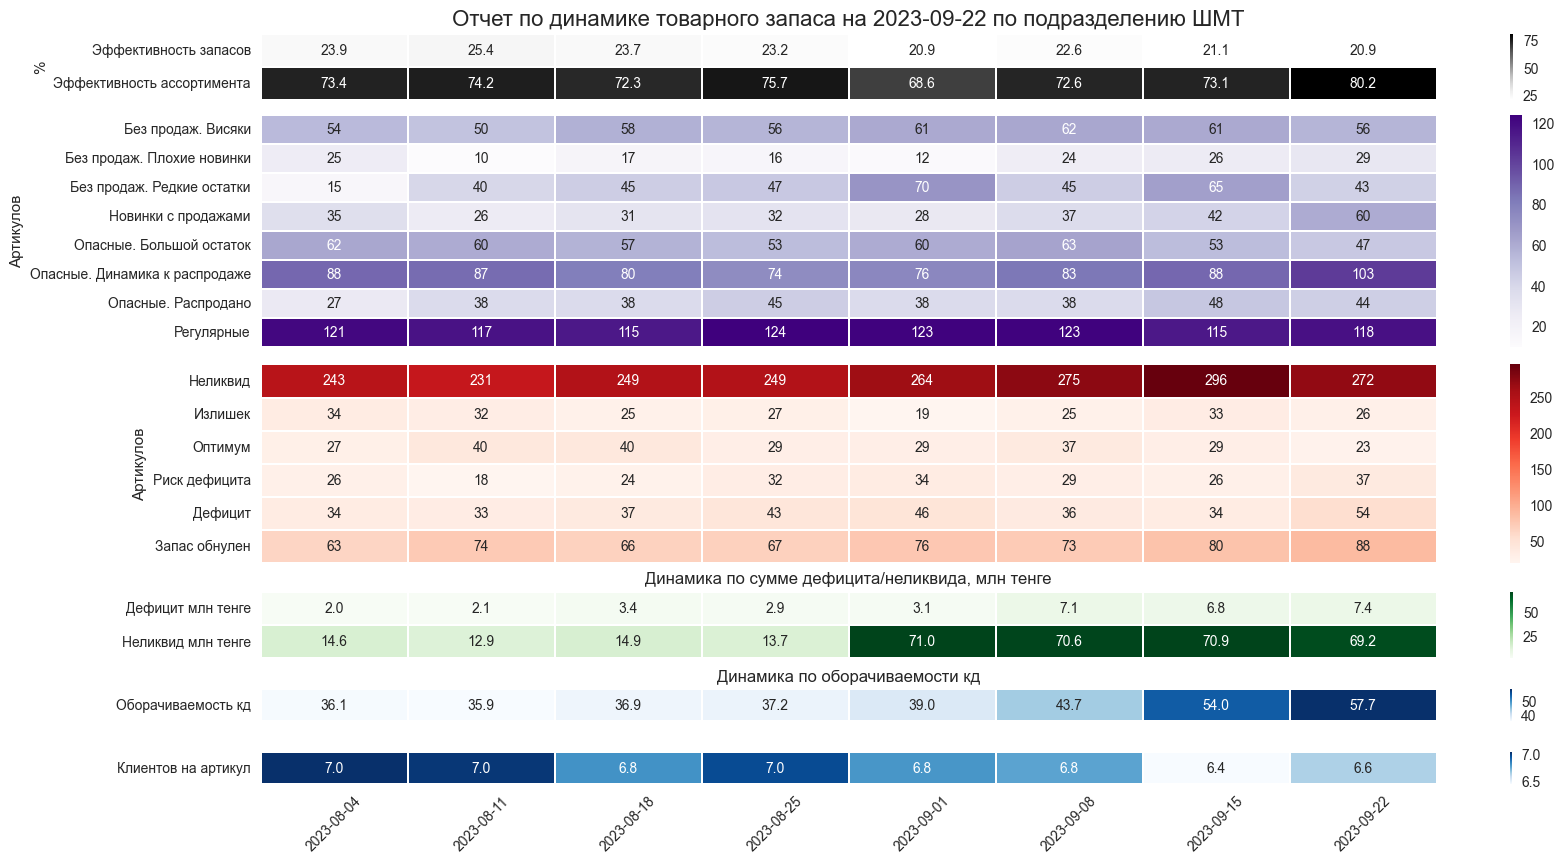

In [381]:
#Визуализация таблицы общих показателей в динамике
fig = plt.figure(figsize=[15,9])
ax0 = fig.add_axes([0.12,   0.86,  0.98, 0.105*0.7])
ax1 = fig.add_axes([0.12,   0.586,  0.98, 0.368*0.7])
ax2 = fig.add_axes([0.12, 0.345, 0.98, 0.316*0.7])
ax3 = fig.add_axes([0.12, 0.24, 0.98, 0.105*0.7])
ax4 = fig.add_axes([0.12, 0.17, 0.98, 0.05*0.7])
ax5 = fig.add_axes([0.12, 0.1, 0.98, 0.05*0.7])

if table4.shape[0] > 25:
    table4 = table4.iloc[-25:,:]

cat_list = ['Эффективность запасов','Эффективность ассортимента']
heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Greys', linewidths=0.1, ax=ax0) 
heat.set_title('Отчет по динамике товарного запаса на ' +str(Stocks['ДАТА'].dt.date.max()) + ' по подразделению '+str(region),fontdict={'size': 16})
heat.axes.set_ylabel('%')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Без продаж. Висяки','Без продаж. Плохие новинки',	'Без продаж. Редкие остатки',	'Новинки с продажами',
            'Опасные. Большой остаток',	'Опасные. Динамика к распродаже',	'Опасные. Распродано',	'Регулярные']
heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.0f', cmap='Purples', linewidths=0.1, ax=ax1) 
#heat.set_title('Отчет по динамике товарного запаса на ' +str(Stocks['ДАТА'].dt.date.max()) + ' по подразделению '+str(region),fontdict={'size': 16})
heat.axes.set_ylabel('Артикулов')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')


cat_list = ['Неликвид','Излишек','Оптимум','Риск дефицита','Дефицит','Запас обнулен']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.0f', cmap='Reds', linewidths=0.1, ax=ax2) 
#heat.set_title('Динамика по типам остатка')
heat.axes.set_ylabel('Артикулов')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Дефицит млн тенге','Неликвид млн тенге']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Greens', linewidths=0.1, ax=ax3) 
heat.set_title('Динамика по сумме дефицита/неликвида, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Оборачиваемость кд']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Blues', linewidths=0.1, ax=ax4) 
heat.set_title('Динамика по оборачиваемости кд')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.yaxis.set_tick_params(rotation=0)
heat.xaxis.set_ticklabels('')

cat_list = ['Клиентов на артикул']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Blues', linewidths=0.1, ax=ax5) 
#heat.set_title('Число клиентов на артикул')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.yaxis.set_tick_params(rotation=0)
heat.xaxis.set_tick_params(rotation=45)


plt.tight_layout()
fig.savefig('output\Динамика '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

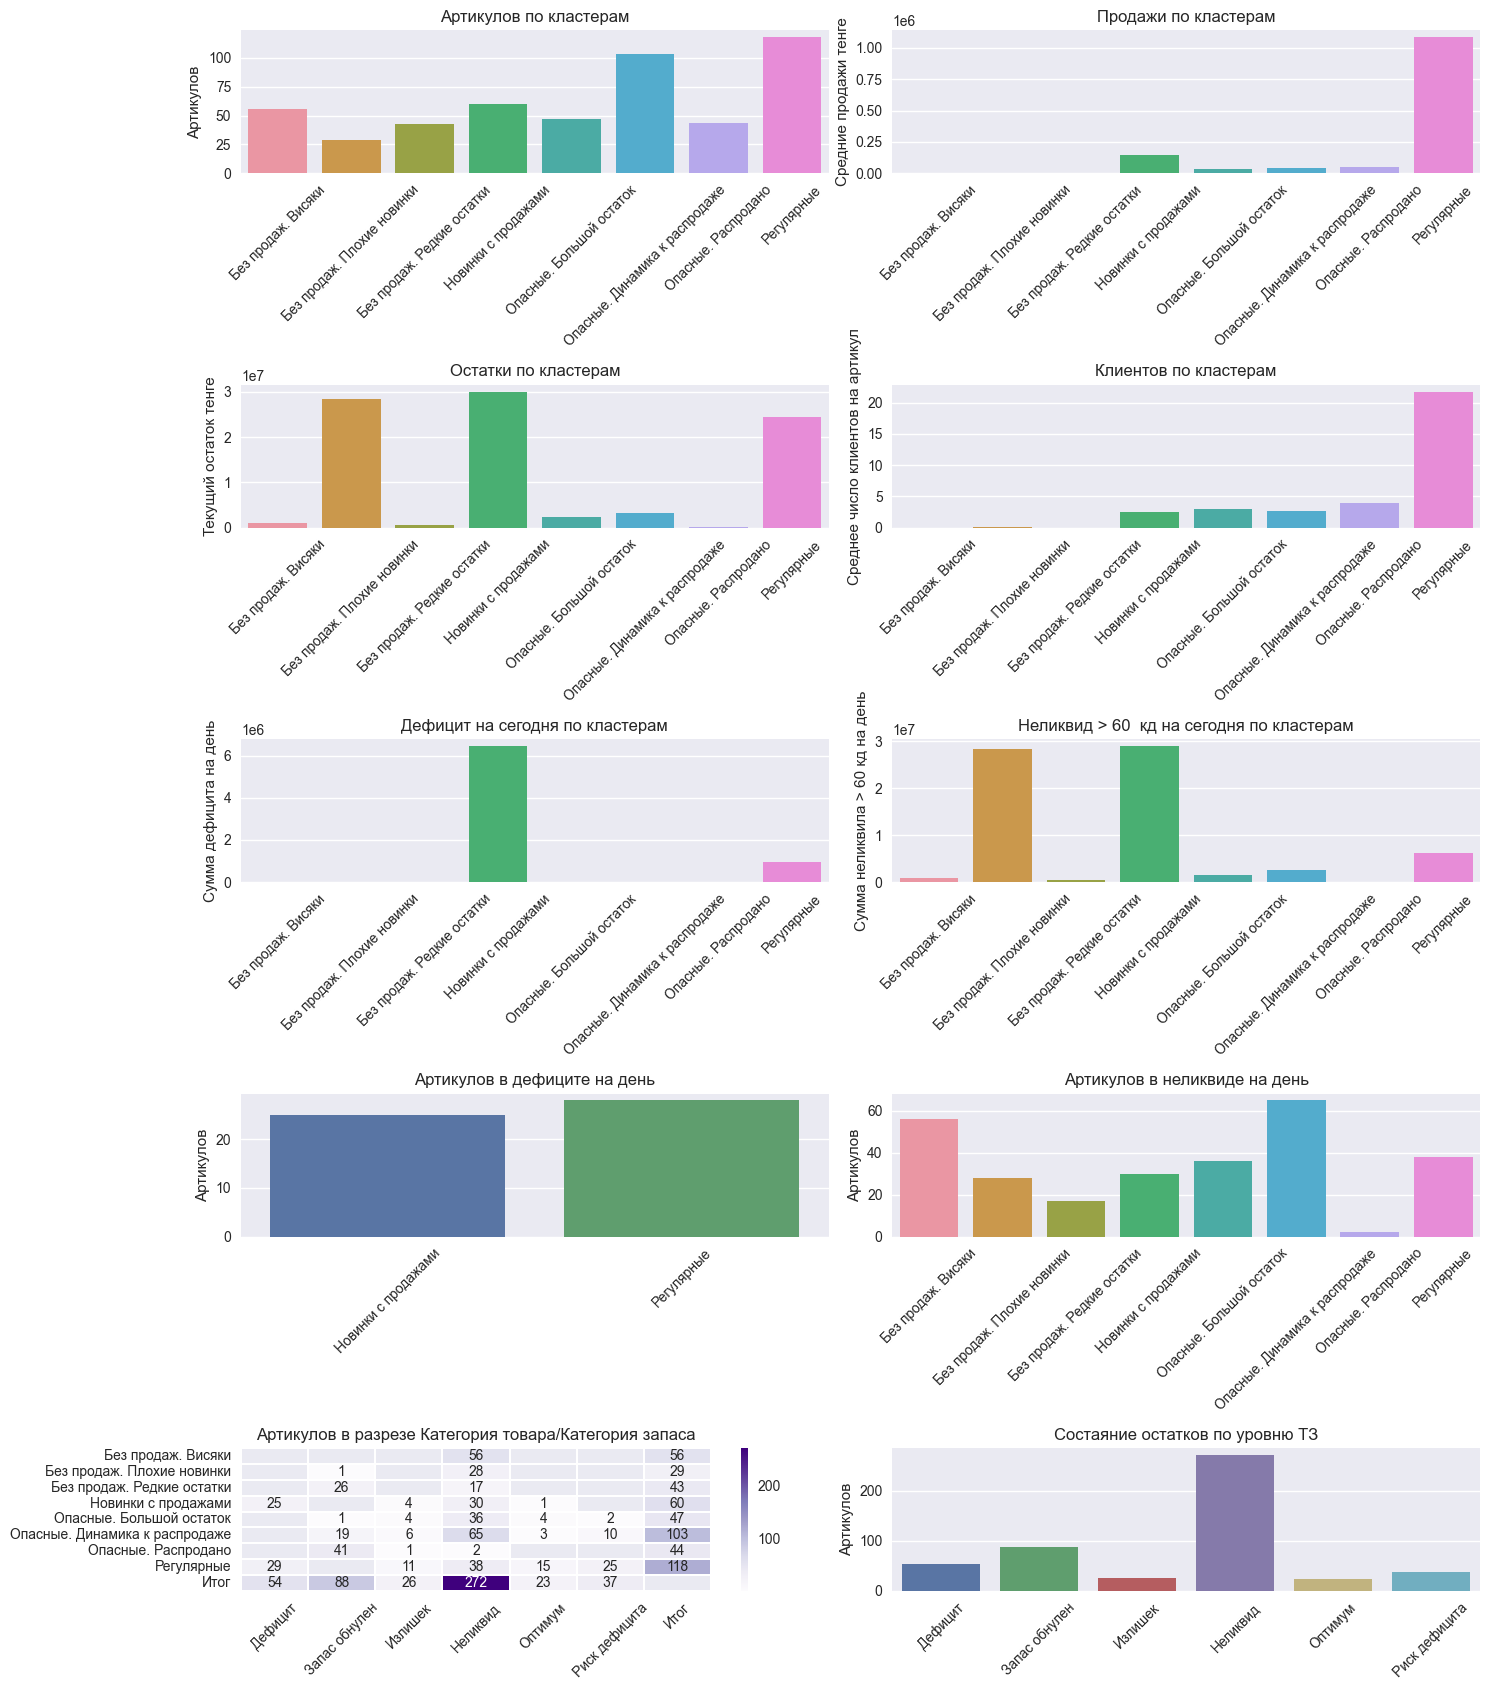

In [382]:
fig, axes = plt.subplots(5,2,figsize=[15,17])

table3 = piv_nom.groupby('cluster_name')['sales_mean_$'].sum()
bar1 = sns.barplot( x=table3.index, y=table3.values, ax=axes[0][1])
bar1.axes.set_ylabel('Средние продажи тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Продажи по кластерам')


table3 = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[0][0])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_stock_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][0])
bar1.axes.set_ylabel('Текущий остаток тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Остатки по кластерам')

table3 = piv_nom.groupby('cluster_name')['КЛИЕНТОВ'].mean()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][1])
bar1.axes.set_ylabel('Среднее число клиентов на артикул')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Клиентов по кластерам')

table3 = piv_nom[piv_nom['cluster_name']!='Под заказ'].groupby('cluster_name')['curr_deficit_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[2][0])
bar1.axes.set_ylabel('Сумма дефицита на день')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Дефицит на сегодня по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_overstok_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[2][1])
bar1.axes.set_ylabel('Сумма неликвила > 60 кд на день')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Неликвид > 60  кд на сегодня по кластерам')

table3 = piv_nom[(piv_nom['curr_deficit_$'] > 0) & (piv_nom['cluster_name'] != 'Под заказ')].groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[3][0])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов в дефиците на день')

table3 = piv_nom[piv_nom['curr_overstok_$'] > 0].groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[3][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов в неликвиде на день')


table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='stock_zone', values='АРТИКУЛ', aggfunc='nunique')
row_sum = table3.sum()
table3 = table3.T
col_sum = table3.sum()
table3 = pd.concat([table3, row_sum], axis=1)

table3 = table3.T
table3 = pd.concat([table3, col_sum], axis=1)
table3 = table3.rename({0:'Итог'}, axis=1)
table3 = table3.rename({0:'Итог'}, axis=0)
table3
heat = sns.heatmap(table3, annot=True, fmt='.0f', cmap='Purples', linewidths=0.1, ax=axes[4][0]) 
heat.set_title('Артикулов в разрезе Категория товара/Категория запаса')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.xaxis.set_tick_params(rotation=45)


table3 = table3.drop('Итог', axis=1).drop('Итог', axis=0).sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[4][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Состаяние остатков по уровню ТЗ')
plt.tight_layout()
fig.savefig('output\Параметры по категориям '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

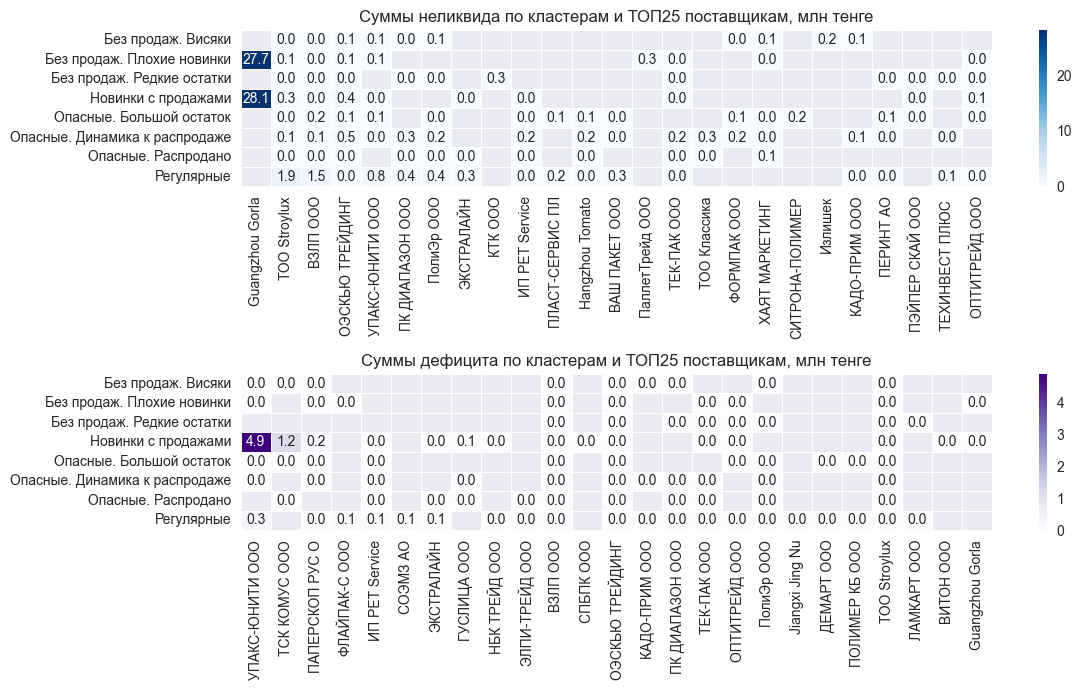

In [383]:
fig, axes = plt.subplots(2,1,figsize=[12,7])


max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_overstok_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_overstok_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Blues',linewidth=.5, annot=True, fmt='.1f', ax=axes[0])
heat.set_title('Суммы неликвида по кластерам и ТОП25 поставщикам, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_deficit_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_deficit_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap="Purples",linewidth=.5, annot=True, fmt='.1f', ax=axes[1])
heat.set_title('Суммы дефицита по кластерам и ТОП25 поставщикам, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')


plt.tight_layout()
fig.savefig('output\Аналитика поставщики '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

Посмотрим на получившиеся визуализации. Даже в смыле сравнения с basiline, который выделяет неликвиды или дефициты без деления на кластеры. Благодаря кластеризации мы понимаем, какого рода у нас, например неликвиды и что нам нужно, закупщиков обучать или с продажниками работать.

Более того, мы закрыди задачу взвешенной отчетности. Мы использоавали кластеры, чтобы получить взвешенный показатель эффективности ассортимента. И отделить эффективность ассортимента, от эффективности запасов.

Посмотрим на отчеты, которые мы сформировали:

1. **Отчет в динамике**. Показывает слабые зоны с учетом динамики. Автоматически обновляется при использовании на новых данных.
2. **Отчет по категориям**. Позволяет при необходимости подробно углубиться в текущие проблемы, которые видны в динамике.
3. **Отчет в разрезе поставщиков**. Позволяет быстро вычислить по каким Поставщикам основные проблемы по дефицитам и неликвидам и именно с учетом нашей сегментации товаров на кластеры. Например неликвид Регулярных товаров не является обычно столь значимым и требующим быстрой реакции, как Неликвид в группе висяков.

Такая аналитика в baseline варианте просто невозможна, т.к. не делит товары по сегментам, а ко всем относится одинаково, просто по показателю оборачиваемости

**Расчет рекомендованного ориентира для заказа, а также формирование и вывод рекомендаций для закупщика**

Для начала нужно понимать, что заказ зависит в том числе о данных о том, как часто заказывается товар у того или иного поставщика по графику, а также того, как долго товар от поставщика едет. Я совместно с закупщиками Компании сформировал специальные данные для этого. Загрузим их:

In [384]:
suppliers = pd.read_excel('data\ПАРАМЕТРЫ ПОСТАВЩИКОВ.xlsx')
suppliers['ПОСТАВЩИК'] = suppliers['ПОСТАВЩИК'].apply(lambda x: x[:15])

Напишем функцию расчета заказа с учетом товарного сегмента. Она будет выдавать нам рекомендованное количество к заказу, а также рекомендацию для закупщика.

cat_list = ['Без продаж. Висяки','Без продаж. Плохие новинки',	'Без продаж. Редкие остатки',	,
            'Опасные. Большой остаток',	'Опасные. Динамика к распродаже',	'Опасные. Распродано']

In [389]:
def count_orders(art):
    #Собираем данные по артикулу по плечу поставки и регулярности прихода, по умолчанию 10 и 8
    regularity_days = 10
    transport_days = 8
    
    supplier = piv_nom[piv_nom['АРТИКУЛ'] == art]['ПОСТАВЩИК'].iloc[0]
    
    if supplier in list(suppliers['ПОСТАВЩИК'].values):
        regularity_days = suppliers[suppliers['ПОСТАВЩИК']== supplier]['РЕГУЛЯРНОСТЬ ДНИ'].iloc[0]
        transport_days = suppliers[suppliers['ПОСТАВЩИК']== supplier]['ПЛЕЧО ДНИ'].iloc[0] 
    
    #Расчитаем параметры
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    mean_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_mean'].iloc[0]
    stock_on_income = max([curr_stock - mean_level*transport_days,0])
    aim_stock = risk_zone_level + mean_level*regularity_days
    order = aim_stock - stock_on_income
    part_of_max_client = piv_nom[piv_nom['АРТИКУЛ'] == art]['ДОЛЯ МАКС КЛИЕНТА'].iloc[0]
    
    #Расчитаем заказ в зависимости от группы
    #Для регулярных 
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Регулярные','Новинки с продажами']:
        max_client = ''
        max_manager = ''
        if part_of_max_client > 0.8: #Это условие было введено эмперически при тестировании системы с закупщиками. ВОспринимать как эвристику
            max_client = Sales[Sales['АРТИКУЛ'] == art].groupby('КЛИЕНТ')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index[0]
            max_manager = Sales[Sales['КЛИЕНТ'] == max_client]['МЕНЕДЖЕР'].iloc[0]
            max_manager = ' менеджера '+ str(max_manager)
            max_client = ' если сохраняются заказы клиента ' + str(max_client) + max_manager
        
        max_client = 'Верить автозаказу' + max_client
        if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] == 'Новинки с продажами':
            max_client = 'Новинка! ' + max_client
            
        return max([order,0]), max_client
    #Для опасных кластеров
    #В тестовых версиях с закупщиками тут давалась рекомендация и предупреждение.
    #На данном этапе пока отказались от этого и рекомендация по количеству не дается
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Опасные. Распродано','Опасные. Динамика к распродаже','Опасные. Большой остаток']:
        
        d = dict()
        man_list = list(Sales[Sales['АРТИКУЛ'] == art].groupby('МЕНЕДЖЕР')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index)
        for man in man_list:
            dff = Sales[Sales['АРТИКУЛ'] == art].groupby(['МЕНЕДЖЕР','КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by='ПРОДАЖА ШТ',ascending=False)
            dff = dff[dff['МЕНЕДЖЕР']== man]['КЛИЕНТ'].unique()
            d[man] = list(dff)
        
        return 0, 'Опасно, проверить!: ' + str(d)
    
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Без продаж. Висяки','Без продаж. Плохие новинки','Без продаж. Редкие остатки']:
        return 0, '---'
   

Загрузим в дата сет признаки заказа и текстовой рекомендации

In [390]:
piv_nom['order'] = piv_nom['АРТИКУЛ'].apply(lambda x: count_orders(x)[0])
piv_nom['order_comment'] = piv_nom['АРТИКУЛ'].apply(lambda x: count_orders(x)[1])
piv_nom['order_$'] = piv_nom['order'] * piv_nom['ЦЕНА']

In [391]:
piv_nom[['АРТИКУЛ','ДУБЛИКАТЫ', 'ТОВАР', 'ПОСТАВЩИК', 'АГ', 'НГ','cluster_name','ДОЛЯ МАКС КЛИЕНТА',
         'sales_sym','order','order_$', 'order_comment']].sort_values(by='order_$', ascending=False).to_excel('output\Потребность '+ str(region) +' '
                                                                   +str(Stocks['ДАТА'].dt.date.max())+'.xlsx')

Создадим еще полезную выгрузку для закупщика, которая будет содержать кластер, уровень дефицита и уровень неликвида

In [397]:
mask = (piv_nom['curr_deficit'] > 0)
piv_nom[mask][['АРТИКУЛ','ДУБЛИКАТЫ', 'ТОВАР', 'ПОСТАВЩИК', 'АГ', 'НГ','cluster_name','ДОЛЯ МАКС КЛИЕНТА',
         'sales_sym','curr_deficit','curr_deficit_$']].sort_values(by=['curr_deficit_$'], ascending=False).to_excel('output\Дефициты '+ str(region) +' '
                                                                   +str(Stocks['ДАТА'].dt.date.max())+'.xlsx')

In [398]:
mask = (piv_nom['curr_overstok'] > 0)
piv_nom[mask][['АРТИКУЛ','ДУБЛИКАТЫ', 'ТОВАР', 'ПОСТАВЩИК', 'АГ', 'НГ','cluster_name','ДОЛЯ МАКС КЛИЕНТА',
         'sales_sym','curr_overstok','curr_overstok_$']].sort_values(by=['curr_overstok_$'], ascending=False).to_excel('output\Неликвиды '+ str(region) +' '
                                                                   +str(Stocks['ДАТА'].dt.date.max())+'.xlsx')